## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers
random.seed(42)

 Read in the `ab_data.csv` data. Store it in `df`. 


In [2]:
#load data
df = pd.read_csv("ab_data.csv")

In [3]:
#check the data
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
#check duplicates
df.duplicated().sum()

0

 Use the below cell to find the number of rows in the dataset.

In [6]:
df.shape

(294478, 5)

 The number of unique users in the dataset.

In [7]:
df.user_id.nunique()

290584

The proportion of users converted.

In [8]:
df.converted.mean()

0.11965919355605512

 The number of times the `new_page` and `treatment` don't line up.

In [9]:
#Number of time tratment  and new_page don't match
df.query("group == 'treatment' & landing_page == 'old_page'").shape[0] + df.query("group == 'control' & landing_page == 'new_page'").shape[0] 

3893

 Do any of the rows have missing values?

In [10]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

 For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 
 


In [11]:
#remove the rows where landing_page and group which are not aligned
ls = df.query("group == 'control' & landing_page == 'new_page'").index
ls2 = df.query("group == 'treatment' & landing_page == 'old_page'").index

In [12]:
df2 = df

In [13]:

df2.drop(ls,axis=0,inplace=True)
df2.drop(ls2,axis=0,inplace=True)

In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**. 

In [16]:
df2.user_id.duplicated().sum()

1

What is the row information for the repeat **user_id**? 

In [17]:
df2[(df2.user_id.duplicated() == True)]


,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
df2.drop(df[df.user_id == 773192].index,inplace=True)

In [19]:
df2.user_id.duplicated().sum()

0

What is the probability of an individual converting regardless of the page they receive?

In [20]:
df2.converted.mean()

0.11959749882133504

Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
df2.groupby('group')['converted'].value_counts()

group      converted
control    0            127785
           1             17489
treatment  0            128045
           1             17264
Name: converted, dtype: int64

In [22]:
17489 / (17489+127785)

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
17264 / (17264+128045)

0.11880888313869065

What is the proportion that an individual received the new page?

In [24]:
len(df2[df2.landing_page == 'new_page'])/len(df2)

0.5000602237570677

**Because there is no significant difference in the conversion rate among the controled group and treatment group, it is very difficult to say that new page leads to more convertion. Also, data is showing that people in the controled group have more convertion rate than treatment group. Hence, we do not have sufficient evidence to say that new treatment is working better. So, we need more data to come to conclusion about the new treatment conversion rate.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$$H_0: P_{new} - P_{old} <= 0$$
$$H_1: P_{new} - P_{old}  > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2['converted'].mean()
print('Convert rate for p_new under the null :: ',p_new)

Convert rate for p_new under the null ::  0.11959749882133504


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = df2['converted'].mean()
print('Convert rate for p_old under the null :: ',p_old)

Convert rate for p_old under the null ::  0.11959749882133504


c. What is $n_{new}$?

In [27]:
# Get dataframe with all records from new page and check the conversion rate

n_new = len(df2.query("landing_page == 'new_page'"))           
print('n_new :: ', n_new)

n_new ::  145309


d. What is $n_{old}$?

In [28]:
# Get dataframe with all records from old page and check the conversion rate

n_old = len(df2.query("landing_page == 'old_page'"))           
print('n_old :: ', n_old)

n_old ::  145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.binomial(n_new,p_new)
print('new_page_converted :: ',new_page_converted)

new_page_converted ::  17407


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.binomial(n_old,p_old)
print('new_page_converted :: ',old_page_converted)

new_page_converted ::  17356


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
(new_page_converted/n_new) - (old_page_converted/n_old)

0.0003221997415213812

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

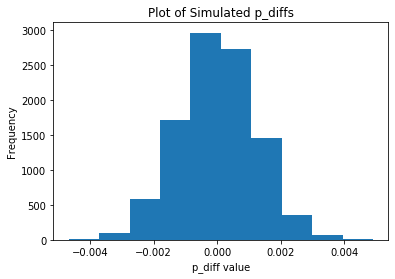

In [33]:
plt.xlabel('p_diff value')
plt.ylabel('Frequency')
plt.title('Plot of Simulated p_diffs');
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
p_diff_orig = df2[df2['landing_page'] == 'new_page']['converted'].mean() -  df2[df2['landing_page'] == 'old_page']['converted'].mean()
print('p_diff from ab_data.csv :: ',p_diff_orig)

p_diff from ab_data.csv ::  -0.0015774213617705535


In [35]:
p_diffs = np.array(p_diffs)
p_diff_proportion = (p_diff_orig < p_diffs).mean()
print('proportion of p_diffs greater than p_diffs from ab_data.csv :: ',p_diff_proportion)

proportion of p_diffs greater than p_diffs from ab_data.csv ::  0.9012


In [36]:
np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

(-0.0023760600803616554, 0.002324911812790583)

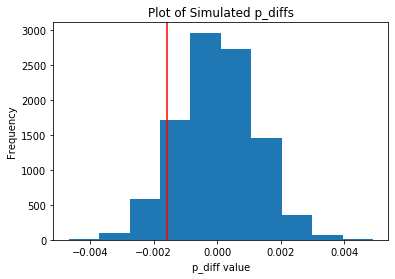

In [37]:
plt.xlabel('p_diff value')
plt.ylabel('Frequency')
plt.title('Plot of Simulated p_diffs');
plt.hist(p_diffs);
plt.axvline(p_diff_orig,color='red');


Here, p-value is computed (in our case it is the probability of not observing any difference between convertion rates of control and treatment groups if the null hypothesis is true). In order to reject the null hypothesis, the p-value should be below our α level of 0.05 (agreed level of 5% chance of committing a Type I error if the null is true). In our case, the p-value calculated is 0.9, too high for us to be able to reject the null hypothesis. There is no sufficient evidence to say that there is convertion difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

C:\Users\Shivam\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Shivam\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [39]:
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145309)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3102408579271012, 0.9049428161159749)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

 A z-score is the number of standard deviations from the mean a data point is (obs_diff). The z-score and p-value computed in the previous question agree with the findings in parts j. and k (p-value == 0.9).

<a id='regression'></a>
### Part III - A regression approach

We will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Because we are dealing with binary output, Logistic regression should be used.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [44]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [45]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:               8.068e-06
Time:                        15:59:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1901
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

The p-value calculated here is 0.190. This is because the Logit Regression is based on a two-tailed test. 0.190 is still greater then 0.05 (our $\alpha$), so we still cannot reject our null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior. Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? 

In [47]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [49]:
# Check what countries are in the new dataset
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [48]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [50]:
### Fit Your Linear Model And Obtain the Results
# Train the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:               1.520e-05
Time:                        16:02:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
us             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [51]:
# Create additional columns specifying what user/country converted
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [52]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:               3.481e-05
Time:                        16:03:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1922
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

Looking at p-values for all variables (all higher than 0.05) we can say that interactions between page and country have no significant effects on conversion.

<a id='conclusions'></a>
## Conclusions

he conclusion of the whole study and the general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.

Although there could be other variables identified regarding users which could result in rejecting our null hypothesis (and would require additional resources/money and time), the so-far analysis results would bias me toward suggesting to drop the new page as not bringing much value and focus on something else (maybe another brand new page with other features to test).

